Build robust dataset to solve real-world problems and see how your data preparation ultimately impacts how effective your models are. Additionally, building better features is after data, the second most important way to impact Machine Learning performance. In this part, the dataset is neatly divided into train and test set. What I will do is to deal with missing values and choose right features and their formats for the right algorithms then evaluate their performance, according to the evaluation, tune the features and update this process until no improvement on model performance.

### 1. Import libraries for data preprocessing

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [178]:
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
# Machine Learning algorithms
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
# Fine tune hyper-parameters
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

In [361]:
# Reading datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submit = pd.read_csv("Sample_Submission.csv")

# Saving id variables to create final submission
ids_test = test['User_ID'].copy()
product_ids_test = test['Product_ID'].copy()

In [362]:
train.shape

(550068, 12)

The train and test datasets contained 550,068 and 233,599 instances respectively. There are 11 features, four of them are masked and two of them are with missing values.

In [6]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [7]:
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


In [8]:
test.shape  

(233599, 11)

### 2. Data Pre-Processing

In [109]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


#### 2.1 Checking for missing value

In [110]:
print('Train columns with null values:')
print(train.isnull().sum())
print("-"*10)
print('Test/Validation columns with null values:')
print(test.isnull().sum())
print("-"*10)

Train columns with null values:
User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64
----------
Test/Validation columns with null values:
User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64
----------


• Fill in missing values 

In EDA part, we detect that variables 'Product_Category_2' and 'Product_Category_3' both have 31.57%, 69.67%, 30.97% and 69.59% missing values in training set and test set,respectively. Since there are too many missing values in these two features, compared to filling them with other numbers and adding noise to the dataset, I decide to directly drop them. (Further, I actually run the model with these two features and without them, the result shows that RMSE is smaller if dataset does not contain two features. However, I am not sure whether the result will improve a lot if I use other imputation method like building a model instead of filling with subjective numbers.)

In [363]:
# drop 'Product_Category_2' and  'Product_Category_3' variables since too many missing values
train.drop(['Product_Category_2','Product_Category_3'],inplace=True,axis=1)
test.drop(['Product_Category_2','Product_Category_3'],inplace=True,axis=1)

#### Summary of data :

<b> Age : </b>  should be treated as numerical. It presents age groups.

<b>City_Category:  </b>We can convert this to numerical as well, with dummy variables. Should take a look at the frequency of the values.

<b>Occupation : </b>It seems like it has at least 16 different values, should see frequency and try to decrease this value.

<b>Gender:</b> There are possibly two gender, we can make this binary.

<b>Product_ID:</b> Should see if the string “P” means something and if there are other values.

<b>Stay_In_Current_City_Years: </b>We should deal with the ‘+’ symbol.

<b>Product_Category_2 and Product_Category_3 :</b> Have NaN values. We have already dropped it out.

In [364]:
#Apply function len(unique()) to every data variable
train.apply(lambda x: len(x.unique()))

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Purchase                      18105
dtype: int64

#### 1.2 Frequency Analysis

In [27]:
category_cols = train.select_dtypes(include=['object'])
for col in category_cols:
 #Number of times each value appears in the column
    frequency = train[col].value_counts()
    print('\nThis is the frequency distribution for ' + col + ':')
    print(frequency)


This is the frequency distribution for Product_ID:
P00265242    1880
P00025442    1615
P00110742    1612
P00112142    1562
P00057642    1470
             ... 
P00081342       1
P00301442       1
P00083142       1
P00364342       1
P00081642       1
Name: Product_ID, Length: 3631, dtype: int64

This is the frequency distribution for Gender:
M    414259
F    135809
Name: Gender, dtype: int64

This is the frequency distribution for Age:
26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

This is the frequency distribution for City_Category:
B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

This is the frequency distribution for Stay_In_Current_City_Years:
1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64


### 2. Feature Engineering

• Five features need to be converted, they include: Product_ID, Gender, Age, City_Category and Stay_In_Current_City_Years.

<b>Product_ID:</b> I first LabelEncoding them directly because I think it seems to have no affect on the model and final scores. However, I was wrong and made mistake here. I trid several different ideas to convert it and decide to drop character 'P' and remain the rest numbers which gives me the best performance.

<b> Age :</b> When I explore the dataset I do find that different age groups hold different purchasing patterns. For example, 26-35 age groups are with the greatest purchasing power. Instead of one-hot encoding, I tend to keep the order against purchase amount by mapping the age groups onto specific ages. Modeling result shows that this works and outperforms one-hot encoding way.

<b> Stay_In_Current_City_Years: </b> The same situation as age variable, in order to avoid affecting the data patteren or distribution, for example, people stayed 4+ years do not buy too many products compared with those stay 1 year. Rethink about it and I feel like this makes sense that people living here for a long time do need less goods so less shop Black Friday. However, people just move here tend to shop more because they demand more. Consequently, I still map the values to specific years.

<b>Gender and City_Category: </b> Categorical variables, I used DictVectorizer to label it.

#### 2.1 Label Encoded : Gender, Age, City_Category , Stay_In_Current_City_Years 

In [365]:
# Convert Product ID to numerical values by removing P and convert the rest part to int type
train["Product_ID"] = train["Product_ID"].str.replace("P", "")
train["Product_ID"] = train["Product_ID"].astype(str).astype(int)

test["Product_ID"] = test["Product_ID"].str.replace("P", "")
test["Product_ID"] = test["Product_ID"].astype(str).astype(int)

gender_dict = {'F':0, 'M':1}
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
city_dict = {'A':0, 'B':1, 'C':2}
stay_dict = {'0':0, '1':1, '2':2, '3':3, '4+':4}

In [366]:
train["Gender"] = train["Gender"].apply(lambda x: gender_dict[x])
test["Gender"] = test["Gender"].apply(lambda x: gender_dict[x])

train["Age"] = train["Age"].apply(lambda x: age_dict[x])
test["Age"] = test["Age"].apply(lambda x: age_dict[x])

train["City_Category"] = train["City_Category"].apply(lambda x: city_dict[x])
test["City_Category"] = test["City_Category"].apply(lambda x: city_dict[x])

train["Stay_In_Current_City_Years"] = train["Stay_In_Current_City_Years"].apply(lambda x: stay_dict[x])
test["Stay_In_Current_City_Years"] = test["Stay_In_Current_City_Years"].apply(lambda x: stay_dict[x])

In [185]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null int64
Gender                        550068 non-null int64
Age                           550068 non-null int64
Occupation                    550068 non-null int64
City_Category                 550068 non-null int64
Stay_In_Current_City_Years    550068 non-null int64
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Purchase                      550068 non-null int64
dtypes: int64(10)
memory usage: 42.0 MB


In [186]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 9 columns):
User_ID                       233599 non-null int64
Product_ID                    233599 non-null object
Gender                        233599 non-null int64
Age                           233599 non-null int64
Occupation                    233599 non-null int64
City_Category                 233599 non-null int64
Stay_In_Current_City_Years    233599 non-null int64
Marital_Status                233599 non-null int64
Product_Category_1            233599 non-null int64
dtypes: int64(8), object(1)
memory usage: 16.0+ MB


In [196]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
0,1000001,69042,0,0,10,0,2,0,3,8370
1,1000001,248942,0,0,10,0,2,0,1,15200
2,1000001,87842,0,0,10,0,2,0,12,1422
3,1000001,85442,0,0,10,0,2,0,12,1057
4,1000002,285442,1,6,16,2,4,0,8,7969


In [197]:
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1
0,1000004,128942,1,4,7,1,2,1,1
1,1000009,113442,1,2,17,2,0,0,3
2,1000010,288442,0,3,1,1,4,1,5
3,1000010,145342,0,3,1,1,4,1,4
4,1000011,53842,0,2,1,2,1,0,4


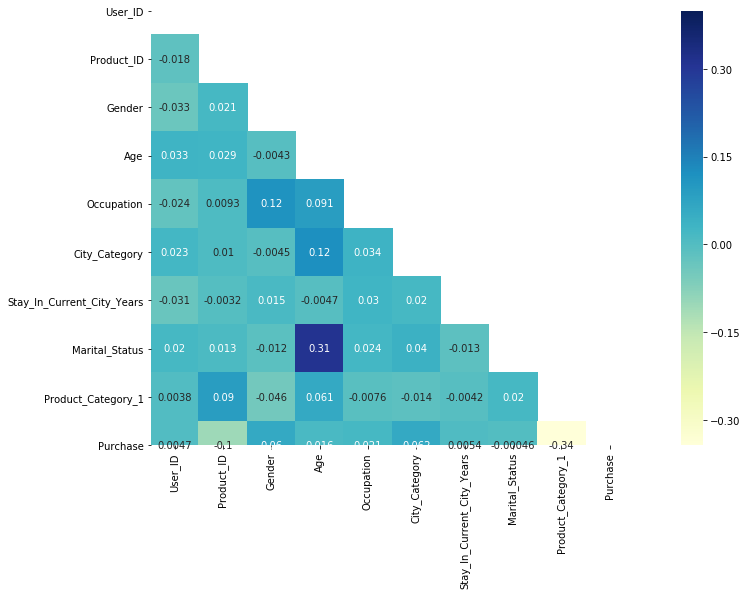

In [198]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(17, 8))
ax = sns.heatmap(corr, mask=mask, square = True, vmax = 0.4,annot=True,cmap="YlGnBu")



It is clear nothing is highly correlated with the Purchase variable. What I could observe is:

Product_Category_1 has a relative strong negative correlation with Purchase.
Since Product_Category_1 variable shows some relation with purchase amount, I think if I have time I may convert it to dummy variable and split each category as a new feature and test the results.

#### 2.2. Function to create count features¶

In [199]:
def getCountVar(compute_df, count_df, var_name):
    grouped_df = count_df.groupby(var_name)
    count_dict = {}
    for name, group in grouped_df: # eg. name is group_name like F, M ; group is data in F, data in M
         count_dict[name] = group.shape[0]

    count_list = []
    for index, row in compute_df.iterrows(): ## read each row in dataframe
        name = row[var_name]  # categroy name , eg. F, M which is the key 
        count_list.append(count_dict.get(name, 0)) # .get(name,0):0 if the key is not found and value is specified.
    return count_list

In [367]:
print ("Getting count features..")
train["Age_Count"] = getCountVar(train, train, "Age")
test["Age_Count"] = getCountVar(test, train, "Age")
print ("Age", np.unique(test["Age_Count"]))

train["Occupation_Count"] = getCountVar(train, train, "Occupation")
test["Occupation_Count"] = getCountVar(test, train, "Occupation")
print ("Occupation", np.unique(test["Occupation_Count"]))

train["Product_Category_1_Count"] = getCountVar(train, train, "Product_Category_1")
test["Product_Category_1_Count"] = getCountVar(test, train, "Product_Category_1")
print ("Cat 1 ",np.unique(test["Product_Category_1_Count"]))

train["User_ID_Count"] = getCountVar(train, train, "User_ID")
test["User_ID_Count"] = getCountVar(test, train, "User_ID")
print ("User id ", np.unique(test["User_ID_Count"])[:10])

train["Product_ID_Count"] = getCountVar(train, train, "Product_ID")
test["Product_ID_Count"] = getCountVar(test, train, "Product_ID")
print ("Product id ", np.unique(test["Product_ID_Count"])[:10])


Getting count features..
Age [ 15102  21504  38501  45701  99660 110013 219587]
Occupation [ 1546  6291  6622  7728  8461 11586 12165 12177 12930 17650 20355 25371
 26588 27309 31179 33562 40043 47426 59133 69638 72308]
Cat 1  [   410    578   1523   3125   3721   3947   5125   5549   6290   9828
  11753  20213  20466  23864  24287 113925 140378 150933]
User id  [ 6  7  8  9 10 11 12 13 14 15]
Product id  [0 1 2 3 4 5 6 7 8 9]


At this time, I decide to LabelEncoder "User_ID" and "Product_ID"

In [381]:
cat_columns_list = ["User_ID", "Product_ID"]
for var in cat_columns_list:
    lb = LabelEncoder()
    full_var_data = pd.concat((train[var],test[var]),axis=0)
    temp = lb.fit_transform(full_var_data)
    train[var] = lb.transform(train[var] )
    test[var] = lb.transform(test[var] )

In [382]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase,Age_Count,Occupation_Count,Product_Category_1_Count,User_ID_Count,Product_ID_Count
0,0,686,0,0,10,0,2,0,3,8370,15102,12930,20213,35,227
1,0,2469,0,0,10,0,2,0,1,15200,15102,12930,140378,35,581
2,0,870,0,0,10,0,2,0,12,1422,15102,12930,3947,35,102
3,0,846,0,0,10,0,2,0,12,1057,15102,12930,3947,35,341
4,1,2832,1,6,16,2,4,0,8,7969,21504,25371,113925,77,203


In [383]:
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Age_Count,Occupation_Count,Product_Category_1_Count,User_ID_Count,Product_ID_Count
0,3,1279,1,4,7,1,2,1,1,45701,59133,140378,14,936
1,8,1126,1,2,17,2,0,0,3,219587,40043,20213,58,254
2,9,2862,0,3,1,1,4,1,5,110013,47426,150933,223,142
3,9,1442,0,3,1,1,4,1,4,110013,47426,11753,223,15
4,10,537,0,2,1,2,1,0,4,219587,47426,11753,70,567


In [370]:
train.to_csv("train_mod.csv", index=False)
test.to_csv("test_mod.csv", index=False)

### 3.Training vs Validation vs Test set

In [384]:
#Divide into Test and Train again
Train=train.loc[train['Purchase'].isnull()==False]

# Split into X_train as training set and X_test as validation set
X = Train.drop(['Purchase'], axis=1)
y = Train['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100,test_size=0.3)

In [385]:
print('Test set size:',test.shape)   
print('Train set size:',X_train.shape)    
print('Validation set size:',X_test.shape)   

Test set size: (233599, 14)
Train set size: (385047, 14)
Validation set size: (165021, 14)


### 4. Evaluation metric
The contest utilizes the root mean squared error(RMSE) to evaluate the final predictions. RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors:



 
RMSE = $\displaystyle\sqrt{\frac{1}{n}\sum_{t=1}^{n}(y_i-\hat{y})^2}$ 

where yi is the ground truth and y^ is the prediction for the corresponding test instance.
 

### 5. Models 
#### 5.1. Short_List promising models

For regression problem, we have a bunch of Machine Learning algorithms as candidates. I plan to train many quick and dirty models from different categories like linear model, SVM and tree model, etc using standard parameters and compare their performance. For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.

In order to train many different models in a reasonable time, I will sample smaller training sets to speed up the process here.

In [386]:
#Sample smaller training sets
Train_sample = Train.sample(n=round(Train.shape[0]*0.1),random_state=10)
X = Train_sample.drop(['Purchase'], axis=1)
y = Train_sample['Purchase']

# 5-fold Cross validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [387]:
Train_sample.shape   

(55007, 15)

Test some basic quick and dirty models :

In [388]:
lr_reg = LinearRegression()
lasso = Lasso(random_state=7)
tree = DecisionTreeRegressor(random_state=7)
rf = RandomForestRegressor()

(1) Linear Regression

In [389]:
score = rmsle_cv(lr_reg)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 4378.6796 (16.6143)



(2) Lasso 

In [390]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 4378.6620 (16.5949)



(3) Random Forest 

In [391]:
import warnings
warnings.filterwarnings('ignore')
score = rmsle_cv(rf)
print("\nRandom Forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest: 2904.4199 (30.4716)



(4) Xgboost

In [396]:
dX = xgb.DMatrix(data=X,label=y)

In [ ]:
# 5-fold Cross validation function 2
n_folds = 5
 
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))


Since Support Vector Regression takes too much time, I do not try it here. It looks tree model is very promising. So I plan to use tree based model to tackle the problem. I am planning to try bagging with base estimator decision tree, random forest, gradient boost and extreme gradient boost methods(xgb). It's not only because they are able to capture the patterns in the dataset but also some of them provide tools to evaluate the importance of features, which might give us insight for feature engineering.

#### 5.1.1  Fine-Tune the System

As we all know, finding the optimal parameters is ambitious and time consuming. I started off randomly searching parameters to narrow down the range then moved to grid search to guarantee get more precise result which could be implemented by GridSearchCV and RandomizedSearchCV sklearn functions. It is wise to use as much data as possible for this step, but fine tuning models really takes long time, considering the convenience of running this kernel, I will use random forest as an example.

#### - Random Forest

Searching parameters randomly helps us narrow down optimal range.

In [214]:
#Random Search
rf = RandomForestRegressor(n_jobs=-1,random_state=10)

param_random = {'n_estimators':range(250,500,100),
               'max_depth':range(25,45,10),
               'min_samples_leaf':range(10,25,5),
               'min_samples_split':range(4,10,4)}

# random search + cross validation
random_rf = RandomizedSearchCV(rf,param_random,cv = 3,scoring='neg_mean_squared_error',n_jobs = -1)
# train model in train set
random_rf.fit(X.values,y.values)
# return search results for each case
result_rf = random_rf.cv_results_
print('Random search results:')
for mean_score, params in zip(result_rf["mean_test_score"], result_rf["params"]):
    print(np.sqrt(-mean_score), params)

Random search results:
2778.049361793556 {'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_depth': 35}
2777.5779029183395 {'n_estimators': 450, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_depth': 25}
2777.5784663556415 {'n_estimators': 450, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_depth': 35}
2781.5772623958214 {'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_depth': 25}
2777.825556371647 {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_depth': 35}
2774.366687684554 {'n_estimators': 450, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 35}
2777.5779029183395 {'n_estimators': 450, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_depth': 25}
2777.825556371647 {'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_depth': 35}
2781.576764946098 {'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_depth': 35}
2781.5772623958214 {'n_estim

In [215]:
# get the best estimator 
best_rdm_rf = random_rf.best_estimator_
# prediction on validation set
rf_predictions = best_rdm_rf.predict(X_test.values)
mse = mean_squared_error(y_test, rf_predictions)
rmse = np.sqrt(mse)
print('Best parameters:',random_rf.best_params_)
print('Random Forest with best parameters now, RMSE on validation set:',rmse)

Best parameters: {'n_estimators': 450, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 35}
Random Forest with best parameters now, RMSE on validation set: 2699.1707116550288


In [ ]:
## Grid Search
rf = RandomForestRegressor(n_jobs=-1,random_state=10)

param_grid = [ { 'n_estimators': [440,460], 
                'max_depth':[24,26,27],
                'min_samples_leaf':[8,12], 
                'min_samples_split':[3,5]}]

## Grid search + cross validation
grid_search_rf = GridSearchCV(rf, param_grid, cv=5,scoring='neg_mean_squared_error',n_jobs = -1)
## Train model in smaller sample set to save running time here
grid_search_rf.fit(X.values, y.values)
## Return search values for each case
cvres_rf = grid_search_rf.cv_results_
print('Grid search results:')
for mean_score, params in zip(cvres_rf["mean_test_score"], cvres_rf["params"]): 
    print(np.sqrt(-mean_score), params)
    

I will use the same idea to tweak the parameters for the rest methods and directly give my optimal parameters for the rest models after extensive tuning.

### 6. Modeling 

Since we knew tree-based model are better to make predictions, I decided to choose the Xgboost model. I will add some features and create two more different Xgboost to check whether accuracy was improved.

#### 6.1 Xgboost Model 1

In [407]:
dtrain = xgb.DMatrix(data=X,label=y)

In [423]:
dtest=xgb.DMatrix(data=test)

Check Cross Validation:

In [408]:
param = {'objective': 'reg:linear','eta': 0.05,"min_child_weight":10,'subsample': 0.8, 'colsample_bytree': 0.7, 
         'silent': 1,'max_depth': 10, 'metrics': 'rmse','as_pandas': True, 'seed': 0}
num_round = 750
##Cross-Valid
model1_cv=xgb.cv(param, dtrain, num_round, nfold=4, seed=2244) # test-rmse-mean : lowest  2699

In [416]:
model1_cv.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10080.113281,7.703208,10080.662841,24.305375
1,9618.011475,7.639614,9619.378662,23.252749
2,9191.440429,10.745710,9194.087158,34.790349
3,8778.282471,11.356666,8782.103027,34.967497
4,8408.845459,23.420259,8413.535644,22.834520


In [417]:
print((model1_cv["test-rmse-mean"]).min())# test-rmse-mean: 2665.65216075

2665.65216075


#### Xgboost_Predict 1:

In [418]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

In [428]:
xg_reg.fit(X,y)
preds_xgboost_1 = xg_reg.predict(test)

[16:42:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### 6.2  Xgboost Model 2
Add min, max, mean purchase price

In [429]:
def getPurchaseVar(compute_df, purchase_df, var_name):
        grouped_df = purchase_df.groupby(var_name)
        min_dict = {}
        max_dict = {}
        mean_dict = {}
        for name, group in grouped_df:
                min_dict[name] = min(np.array(group["Purchase"])) #numpy build-in aggregate min, max, mean for array
                max_dict[name] = max(np.array(group["Purchase"]))
                mean_dict[name] = np.mean(np.array(group["Purchase"]))
                

        min_list = []
        max_list = []
        mean_list =[]
        for index, row in compute_df.iterrows():
                name = row[var_name]
                min_list.append(min_dict.get(name,0))
                max_list.append(max_dict.get(name,0))
                mean_list.append(mean_dict.get(name,0))

        return min_list, max_list, mean_list

In [432]:
#for Sample data
min_price_list, max_price_list, mean_price_list = getPurchaseVar(Train_sample, Train_sample, "User_ID")
Train_sample["User_ID_MinPrice"] = min_price_list
Train_sample["User_ID_MaxPrice"] = max_price_list
Train_sample["User_ID_MeanPrice"] = mean_price_list


In [442]:
min_price_list, max_price_list, mean_price_list = getPurchaseVar(Train_sample, Train_sample, "Product_ID")
Train_sample["Product_ID_MinPrice"] = min_price_list
Train_sample["Product_ID_MaxPrice"] = max_price_list
Train_sample["Product_ID_MeanPrice"] = mean_price_list

In [443]:
Train_sample.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase,...,Occupation_Count,Product_Category_1_Count,User_ID_Count,Product_ID_Count,User_ID_MinPrice,User_ID_MaxPrice,User_ID_MeanPrice,Product_ID_MinPrice,Product_ID_MaxPrice,Product_ID_MeanPrice
413090,3502,513,1,3,20,1,4,1,8,9973,...,33562,113925,203,1249,37,16189,8263.705882,2015,10077,8994.545455
246967,1955,3010,1,2,4,1,3,1,5,3577,...,72308,150933,338,197,1465,19176,8024.250000,1797,7181,5617.055556
268623,5256,510,1,1,0,0,2,0,8,7914,...,69638,113925,475,259,772,17011,7988.363636,3885,10012,7606.166667
404234,2064,2833,1,2,0,1,1,1,8,7824,...,69638,113925,357,30,391,20634,8221.976744,6199,8128,7383.666667
536980,4532,294,1,3,20,1,1,1,1,7666,...,33562,140378,499,218,575,23282,9697.529412,3874,15909,9825.277778


Check cross-validation

In [444]:
X2 = Train_sample.drop(['Purchase'], axis=1)
y2 = Train_sample['Purchase']

In [445]:
dtrain2 = xgb.DMatrix(data=X2,label=y2)

In [446]:
model2_cv=xgb.cv(param, dtrain2, num_round, nfold=4, seed=2244) # test-rmse-mean : lowest  2699

In [447]:
model2_cv.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10079.621826,7.625097,10081.706543,25.740119
1,9605.391358,6.830099,9608.642578,24.445416
2,9159.689942,7.092587,9164.163818,23.454142
3,8734.766358,6.252227,8740.965820,24.025013
4,8333.616699,5.789416,8341.171387,22.865023


In [448]:
print((model2_cv["test-rmse-mean"]).min())# test-rmse-mean: 2307.1296384999996

2307.1296384999996


In [451]:
min_price_list, max_price_list, mean_price_list = getPurchaseVar(test, Train_sample, "User_ID")
test["User_ID_MinPrice"] = min_price_list
test["User_ID_MaxPrice"] = max_price_list
test["User_ID_MeanPrice"] = mean_price_list
min_price_list, max_price_list, mean_price_list = getPurchaseVar(test, Train_sample, "Product_ID")
test["Product_ID_MinPrice"] = min_price_list
test["Product_ID_MaxPrice"] = max_price_list
test["Product_ID_MeanPrice"] = mean_price_list
 

In [452]:
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Age_Count,Occupation_Count,Product_Category_1_Count,User_ID_Count,Product_ID_Count,User_ID_MinPrice,User_ID_MaxPrice,User_ID_MeanPrice,Product_ID_MinPrice,Product_ID_MaxPrice,Product_ID_MeanPrice
0,3,1279,1,4,7,1,2,1,1,45701,59133,140378,14,936,15686,15686,15686.000000,4155,19705,16122.127451
1,8,1126,1,2,17,2,0,0,3,219587,40043,20213,58,254,5887,19702,10511.333333,7943,13632,11994.238095
2,9,2862,0,3,1,1,4,1,5,110013,47426,150933,223,142,768,15985,8903.550000,1913,8873,5633.900000
3,9,1442,0,3,1,1,4,1,4,110013,47426,11753,223,15,768,15985,8903.550000,1419,1419,1419.000000
4,10,537,0,2,1,2,1,0,4,219587,47426,11753,70,567,2138,16222,7422.250000,707,3547,2640.327586


#### Xgboost Predict 2

In [453]:
xg_reg2 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

In [456]:
xg_reg2.fit(X2,y2)
preds_xgboost_2 = xg_reg2.predict(test)

[17:13:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### 6.3 Xgboost Model 3
Add 25%, 75% purchase price

In [473]:
def getPurchaseVar_2(compute_df, purchase_df, var_name):
    grouped_df = purchase_df.groupby(var_name)
    twentyfive_dict = {}
    seventyfive_dict = {}
    for name, group in grouped_df:
        twentyfive_dict[name] = np.percentile(np.array(group["Purchase"]),25)
        seventyfive_dict[name] = np.percentile(np.array(group["Purchase"]),75)
        
    twentyfive_list = []
    seventyfive_list = []
    for index, row in compute_df.iterrows():
        name = row[var_name]
        twentyfive_list.append( twentyfive_dict.get(name,0))
        seventyfive_list.append( seventyfive_dict.get(name,0))
    return twentyfive_list, seventyfive_list


In [471]:
twentyfive_dict = {}
seventyfive_dict = {}
grouped_df = Train_sample.groupby("User_ID")
for name, group in grouped_df:
    twentyfive_dict[name] = np.percentile(np.array(group["Purchase"]),25)
    seventyfive_dict[name] = np.percentile(np.array(group["Purchase"]),75)

twentyfive_list = []
seventyfive_list = []

for index, row in Train_sample.iterrows():
    name = row["User_ID"]
    twentyfive_list.append( twentyfive_dict.get(name,0))
    seventyfive_list.append( seventyfive_dict.get(name,0))

In [474]:
twentyfive_price_list, seventyfive_price_list = getPurchaseVar_2(Train_sample, Train_sample, "User_ID")
Train_sample["User_ID_25PercPrice"] = twentyfive_price_list
Train_sample["User_ID_75PercPrice"] = seventyfive_price_list

twentyfive_price_list, seventyfive_price_list = getPurchaseVar_2(Train_sample, Train_sample, "Product_ID")
Train_sample["Product_ID_25PercPrice"] = twentyfive_price_list
Train_sample["Product_ID_75PercPrice"] = seventyfive_price_list


 

In [476]:
Train_sample.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase,...,User_ID_MinPrice,User_ID_MaxPrice,User_ID_MeanPrice,Product_ID_MinPrice,Product_ID_MaxPrice,Product_ID_MeanPrice,User_ID_25PercPrice,User_ID_75PercPrice,Product_ID_25PercPrice,Product_ID_75PercPrice
413090,3502,513,1,3,20,1,4,1,8,9973,...,37,16189,8263.705882,2015,10077,8994.545455,5413.00,12208.00,8039.00,9922.00
246967,1955,3010,1,2,4,1,3,1,5,3577,...,1465,19176,8024.250000,1797,7181,5617.055556,4047.25,11804.25,4135.25,6982.50
268623,5256,510,1,1,0,0,2,0,8,7914,...,772,17011,7988.363636,3885,10012,7606.166667,5937.00,9827.25,7774.75,8037.25
404234,2064,2833,1,2,0,1,1,1,8,7824,...,391,20634,8221.976744,6199,8128,7383.666667,4904.50,9945.50,7011.50,7976.00
536980,4532,294,1,3,20,1,1,1,1,7666,...,575,23282,9697.529412,3874,15909,9825.277778,5977.00,13549.50,7797.75,11773.00


In [477]:
X3 = Train_sample.drop(['Purchase'], axis=1)
y3 = Train_sample['Purchase']

In [479]:
dtrain3 = xgb.DMatrix(data=X3,label=y3)

In [480]:
model3_cv=xgb.cv(param, dtrain3, num_round, nfold=4, seed=2244) # test-rmse-mean : lowest  2699

In [481]:
model3_cv.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10069.433105,7.670992,10070.123291,24.130139
1,9595.790039,7.063721,9597.719483,23.079220
2,9147.258301,8.019831,9150.352539,21.017296
3,8722.818848,9.104619,8727.070313,19.061096
4,8320.214111,9.136617,8326.130859,17.368865


In [482]:
print((model3_cv["test-rmse-mean"]).min())# test-rmse-mean: 2287.4295045

2287.4295045


#### Xgboost Predict 3

In [484]:
twentyfive_price_list, seventyfive_price_list = getPurchaseVar_2(test, Train_sample, "User_ID")
test["User_ID_25PercPrice"] = twentyfive_price_list
test["User_ID_75PercPrice"] = seventyfive_price_list

twentyfive_price_list, seventyfive_price_list = getPurchaseVar_2(test, Train_sample, "Product_ID")
test["Product_ID_25PercPrice"] = twentyfive_price_list
test["Product_ID_75PercPrice"] = seventyfive_price_list

In [488]:
xg_reg3 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

In [489]:
xg_reg3.fit(X3,y3)
preds_xgboost_3 = xg_reg3.predict(test)

[17:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### 7. Ensemble

Finally, it was time for my finishing move, Ensemble. I built a model model which with weighted average of 3XGB models which had different subset of the above mentioned features as inputs.

In this method, we take an average of predictions from all the models and use it to make the final prediction. SO I used 'WEIGHT AVERAGED'. 

In [490]:
finalpred=(preds_xgboost_1+preds_xgboost_2+preds_xgboost_3)/3